In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
from osgeo import gdal
from gdalconst import *
# permite que una misma celda imprima varios resultados
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings("ignore")
import os

In /home/estefania/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/estefania/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/estefania/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/estefania/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/estefania/.local/lib/python3.6/site-packages/matplo

In [2]:
#directoriosancor="/home/manuela/sancor-2.0/" #MANU
directoriosancor="/home/estefania/Desktop/sancor-2.0/"   #EDU

#directoriochirps="/home/manuela/sancor/CHIRPS/"   #MANU
directoriochirps="/home/estefania/Desktop/lluviasarg/"   #EDU

directoriocsvs=directoriosancor+"1CSV/"
directoriopuntos=directoriocsvs+"Agua/"

In [3]:
#VERA JUAN PABLO
df_puntos_agua = pd.read_csv(directoriopuntos+"AguaVera21022019_trans.csv")
e = 11
directoriolectura=directoriocsvs+"Vera_so_csvs/"
prefijolectura="Vera_so_" 
long = df_puntos_agua.Long_trans[e]
lat = df_puntos_agua.Lat_trans[e]

In [14]:
#NICOLAS
df_puntos_agua = pd.read_csv(directoriopuntos+"09_marzo_2015.csv")
e=3
directoriolectura=directoriocsvs+"nicolas_csvs/"
prefijolectura="nicolas_"     
long=float(df_puntos_agua.Longitud[e].replace(",","."))
lat=float(df_puntos_agua.Latitud[e].replace(",","."))

In [4]:
listadefechas = []
anios=range(2010,2020)
fechasporanio=range(1,365,8)
for yy in anios:
    for d in fechasporanio:
        listadefechas.append(str(yy)+"%03d"%d)   

In [5]:
def mescalendario(juliano):
    b=int(juliano[-3:])
    mes=1
    while b>31:
        b-=duracionmeses(juliano[2:4])[mes-1]
        mes+=1
    return juliano[:4] + "." + str(mes).zfill(2)

def duracionmeses(año):
    if int(año[-2:])%4==0:
        lista=[31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    else:
        lista=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    return lista

In [6]:
def pixelado (archivo_tif,longitud,latitud, k):
    #xOrigin = transform[0], yOrigin = transform[3], pixelWidth = transform[1], pixelHeight = -transform[5] 
    transform = archivo_tif.GetGeoTransform()
    in_band = archivo_tif.GetRasterBand(1)
    in_data = in_band.ReadAsArray(0, 0, archivo_tif.RasterXSize, archivo_tif.RasterYSize)

    col = int((longitud - transform[0]) / transform[1])
    row = int((latitud - transform[3]) / transform[5])
    
    arreglo = []
    for i in range(-k,k+1):
        for j in range(-k,k+1):
            arreglo.append(in_data[row+i][col+j])
    arreglo = np.array(arreglo)
    return arreglo

In [7]:
lista_data_lluvias = []
for i in range (len(listadefechas)): 
    in_ds = gdal.Open(directoriochirps+"chirps-v2.0." + mescalendario(listadefechas[i]) + "_arg.tif")
    lluvia = pixelado (in_ds,long,lat, 0)
    lista_data_lluvias.append(lluvia)
    del in_ds
            
df_lluvias = pd.DataFrame(data = lista_data_lluvias)
df_lluvias = df_lluvias.rename(columns = {0:"promedio_sinnorm"})
df_lluvias['lluvias'] = df_lluvias['promedio_sinnorm'] / df_lluvias['promedio_sinnorm'].max()
df_lluvias_drop = df_lluvias.drop(labels = "promedio_sinnorm" , axis = 1)

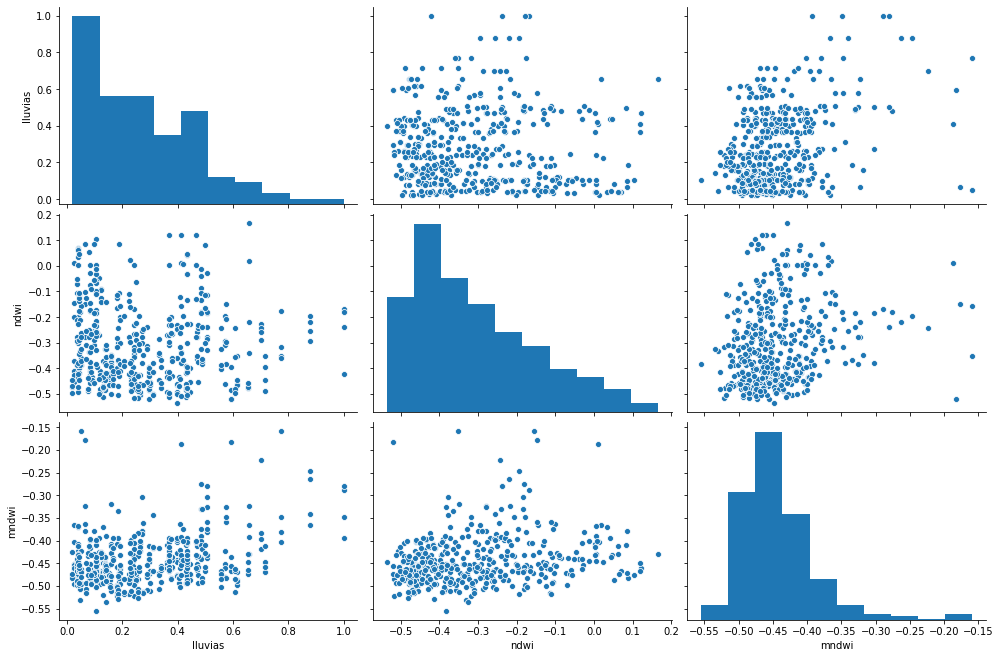

In [8]:
for k in range(1):
    df_mndwi = pd.read_csv(directoriolectura+prefijolectura+ str(e).zfill(3)+"_mndwi_"+str(2*k+1)+"x"+str(2*k+1) +".csv")
    df_ndwi = pd.read_csv(directoriolectura+prefijolectura+ str(e).zfill(3)+"_ndwi_"+str(2*k+1)+"x"+str(2*k+1) +".csv")

    df_mndwi = df_mndwi.drop(labels = "Unnamed: 0" , axis = 1)
    df_mndwi = df_mndwi.drop(labels = "fecha" , axis = 1)
    df_mndwi = df_mndwi.drop(labels = "indice" , axis = 1)
    df_mndwi = df_mndwi.rename(columns = {"promedio":"mndwi"})

    df_ndwi = df_ndwi.drop(labels = "Unnamed: 0" , axis = 1)
    df_ndwi = df_ndwi.drop(labels = "fecha" , axis = 1)
    df_ndwi = df_ndwi.drop(labels = "indice" , axis = 1)
    df_ndwi = df_ndwi.rename(columns = {"promedio":"ndwi"})
    
    result = pd.concat([df_lluvias_drop, df_ndwi, df_mndwi],axis = 1)
    sns.pairplot(data=result, vars = ["lluvias", "ndwi","mndwi"], height = 3, aspect =1.5)

In [ ]:
f = 4

In [ ]:
df_1 = pd.DataFrame({"lluvia":[0]*f})
framesd = [df_1,df_lluvias]
df_lluvias_mod = pd.concat(framesd, axis=0)
df_lluvias_mod = df_lluvias_mod.reset_index()
df_lluvias_mod = df_lluvias_mod.drop(labels = "index", axis = 1)

In [ ]:
df_2 = pd.DataFrame({"ndwi":[0]*f})
framesn = [df_ndwi,df_2]
df_ndwi_mod = pd.concat(framesn, axis=0)
df_ndwi_mod = df_ndwi_mod.reset_index()
df_ndwi_mod = df_ndwi_mod.drop(labels = "index", axis = 1)

In [ ]:
df_3 = pd.DataFrame({"mndwi":[0]*f})
framesm = [df_mndwi,df_3]
df_mndwi_mod = pd.concat(framesm, axis=0)
df_mndwi_mod = df_mndwi_mod.reset_index()
df_mndwi_mod = df_mndwi_mod.drop(labels = "index", axis = 1)

In [ ]:
freims = [df_lluvias_mod, df_ndwi_mod, df_mndwi_mod]
resultado = pd.concat(freims, axis = 1)

In [ ]:
for i in range (f):
    resultado = resultado.drop(labels = i, axis = 0)
for j in range (len(df_lluvias_mod)-f,len(df_lluvias_mod)):
    resultado = resultado.drop(labels = j, axis = 0)

In [ ]:
sns.pairplot(data=resultado, vars = ["ndwi","mndwi","lluvia"], height = 3, aspect =1.5)